In [1]:
import sklearn
assert sklearn.__version__ >= "0.20"
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import feature_column
from tensorflow.keras.layers import Embedding, LSTM
from tensorflow.keras import layers
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import losses
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
seed = 49

### Generating Text Files

In [2]:
!rm -r text

rm: cannot remove 'text': No such file or directory


In [3]:
!mkdir text
!mkdir text/clickbait
!mkdir text/normal

In [4]:
githubUrl= 'https://raw.githubusercontent.com/mtp9k/Identifying-Clickbait-SYS-60616-/main/'

In [5]:
df = pd.read_csv(f'{githubUrl}clickbait_data.csv')

In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.1,random_state=seed)

In [7]:
train.to_csv('clickbait_train.csv',index=False)
test.to_csv('clickbait_test.csv',index=False)

In [8]:
df = pd.read_csv('clickbait_train.csv')

In [9]:
normal = df.loc[df['clickbait']==0]['headline'].values
clickbait = df.loc[df['clickbait']==1]['headline'].values

In [10]:
def generateTensorflowTextDir(data,folderName):
    for i,line in enumerate(data):
        filename = f'{i}_{folderName}'
        with open(f"text/{folderName}/{filename}.txt", "w") as outfile:
            outfile.write(line)

In [11]:
generateTensorflowTextDir(normal,'normal')

In [12]:
generateTensorflowTextDir(clickbait,'clickbait')

### Generating Test Data

In [13]:
testData = pd.read_csv(f'{githubUrl}clickbait_test.csv')
testText = testData['headline'].values
testLabels = testData['clickbait'].values

In [14]:
tweetTestData = pd.read_csv(f'{githubUrl}tweets.csv')
tweetTestText = [' '.join(map(lambda x: x.strip("\n;[]\\"), l.split(' '))) for l in tweetTestData.postText]

tweetTestLabels = np.round(tweetTestData['isClickbait'].values)

### Evaluation Helper functions

In [15]:
from sklearn.metrics import accuracy_score
def getAccuracy(labels,predictions):
    return accuracy_score(labels,np.round(predictions))

In [16]:
def export_model(model):
    ouput = tf.keras.Sequential([
      vectorize_layer,
      model,
    ])
    return ouput

In [17]:
def runEvaluation(model,returnPredictions=False):
    model_predictions= model.predict(testText)
    model_accuracy = getAccuracy(testLabels,model_predictions)
    model_tweet_predictions = model.predict(tweetTestText)
    model_tweet_accuracy = getAccuracy(tweetTestLabels,model_tweet_predictions)
    if returnPredictions:
      return model_predictions,model_tweet_predictions
    return model_accuracy,model_tweet_accuracy
    

### Parsing Text Files

In [18]:
# Batch Size -- we set to 1 to just read it in
BATCH_SIZE = 64
DATASET_SIZE = 32000
train_size = 32000 - 6400
test_size =6400
seed = 49

In [19]:
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'text',
    batch_size=BATCH_SIZE,
    class_names=['normal','clickbait'],
    subset='training',
    validation_split=0.2, 
    seed=seed
)

Found 28800 files belonging to 2 classes.
Using 23040 files for training.


In [20]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to normal
Label 1 corresponds to clickbait


In [21]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
   'text/',
    batch_size=BATCH_SIZE,
    class_names=['normal','clickbait'],
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 28800 files belonging to 2 classes.
Using 5760 files for validation.


In [22]:
for x,y in raw_train_ds.take(1):
    print(x[0:10],y[0:10])

tf.Tensor(
[b'Gilchrist scores second fastest Test century'
 b'21 Sad Ass Mets Fan Tweets' b'Tankers taken by pirates in Indian Ocean'
 b'When Do Women Decide To Have Sex'
 b'German supermarket chain uses fingerprint ID for payment'
 b'Jayant "Dr Death" Patel arrested in Oregon, US'
 b"Quebec's Liberal premier Jean Charest wins third term"
 b'Debt Settlers Offer Promises but Little Help'
 b'Zimbabwe bans crop growing in urban areas'
 b'Wikinews interviews a Restore the Fourth organizer'], shape=(10,), dtype=string) tf.Tensor([0 1 0 1 0 0 0 0 0 0], shape=(10,), dtype=int32)


In [23]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    return input_data
    return lowercase

In [24]:
max_features = 5000
sequence_length = 500

vectorize_layer = TextVectorization(
#     standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [25]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [26]:
def vectorize_text(text, label):
    #text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [27]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)

In [28]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [29]:
embedding_dim = 40

## Experiment 1: Simple NN Performance vs Traditional ML

### Base ML Models

In [30]:
def dsToNumpy(ds):
    xList=[]
    yList=[]
    for x,y in ds.unbatch():
        xList.append(x.numpy())
        yList.append(y.numpy())
    xList=np.array(xList)
    yList=np.array(yList)
    return xList,yList
x_train,y_train = dsToNumpy(train_ds)
x_val,y_val = dsToNumpy(val_ds)

In [31]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=10, random_state=seed).fit(x_train, y_train)
predictions=rf.predict(x_val)
predictions

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [32]:
getAccuracy(y_val,predictions)

0.8321180555555555

In [33]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(x_train, y_train)

# make predictions for test data

y_pred = model.predict(x_val)
predictions = [round(value) for value in y_pred]

# evaluate predictions

accuracy = accuracy_score(y_val, predictions)
accuracy


0.878125

0.878125

### Simple LSTM Model

In [34]:
def LSTM_nn():
    model = tf.keras.Sequential([
      layers.Embedding(max_features, embedding_dim,input_length=sequence_length),
      LSTM(32, return_sequences=True),
      layers.GlobalAveragePooling1D(),
      layers.Dropout(0.3),
      layers.Dense(1,activation='sigmoid')])
    return model

In [35]:
lstm_model = LSTM_nn()
optimizer = keras.optimizers.Adam(lr=0.0001)
lstm_model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])
epochs = 5
history = lstm_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/5
360/360 [==============================] - 26s 26ms/step - loss: 0.5953 - accuracy: 0.6004 - val_loss: 0.1661 - val_accuracy: 0.9602
Epoch 2/5
360/360 [==============================] - 9s 25ms/step - loss: 0.1562 - accuracy: 0.9647 - val_loss: 0.1518 - val_accuracy: 0.9655
Epoch 3/5
360/360 [==============================] - 9s 25ms/step - loss: 0.1173 - accuracy: 0.9747 - val_loss: 0.1420 - val_accuracy: 0.9679
Epoch 4/5
360/360 [==============================] - 9s 25ms/step - loss: 0.0775 - accuracy: 0.9853 - val_loss: 0.1441 - val_accuracy: 0.9694
Epoch 5/5
360/360 [==============================] - 9s 25ms/step - loss: 0.0998 - accuracy: 0.9788 - val_loss: 0.1399 - val_accuracy: 0.9701


In [36]:
export_lstm_model = export_model(lstm_model)
lstm_accuracy,lstm_tweet_accuracy = runEvaluation(export_lstm_model)

In [37]:
print('same dataset evaluation accuracy:')
print(lstm_accuracy)
print('twitter dataset evaluation accuracy:')
print(lstm_tweet_accuracy)

same dataset evaluation accuracy:
0.971875
twitter dataset evaluation accuracy:
0.5082


## Experiment 2: NN Architecture Comparisons + Ensemble

### Simple GRU Model

In [39]:
def GRU_nn():
    model = tf.keras.Sequential([
      layers.Embedding(max_features, embedding_dim,input_length=sequence_length),
      layers.GRU(embedding_dim, return_sequences=True),
      layers.GlobalAveragePooling1D(),
      layers.Dropout(0.3),
      layers.Dense(1,activation='sigmoid')])
    return model

In [40]:
gru_model = GRU_nn()
optimizer = keras.optimizers.Adam(lr=0.0001)
gru_model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])
epochs = 5
history = gru_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/5
360/360 [==============================] - 11s 26ms/step - loss: 0.6329 - accuracy: 0.5675 - val_loss: 0.1641 - val_accuracy: 0.9543
Epoch 2/5
360/360 [==============================] - 9s 25ms/step - loss: 0.1499 - accuracy: 0.9584 - val_loss: 0.1093 - val_accuracy: 0.9698
Epoch 3/5
360/360 [==============================] - 9s 25ms/step - loss: 0.0857 - accuracy: 0.9755 - val_loss: 0.0921 - val_accuracy: 0.9712
Epoch 4/5
360/360 [==============================] - 9s 25ms/step - loss: 0.0545 - accuracy: 0.9844 - val_loss: 0.0914 - val_accuracy: 0.9722
Epoch 5/5
360/360 [==============================] - 9s 25ms/step - loss: 0.0363 - accuracy: 0.9900 - val_loss: 0.1000 - val_accuracy: 0.9724


In [41]:
export_gru_model = export_model(gru_model)
gru_accuracy,gru_tweet_accuracy = runEvaluation(export_gru_model)

In [42]:
print('same dataset evaluation accuracy:')
print(gru_accuracy)
print('twitter dataset evaluation accuracy:')
print(gru_tweet_accuracy)

same dataset evaluation accuracy:
0.97625
twitter dataset evaluation accuracy:
0.5209


### BERT Model

In [43]:
!pip install -q tensorflow-text
!pip install -q tf-models-official

     |████████████████████████████████| 3.4MB 14.1MB/s 
     |████████████████████████████████| 1.1MB 15.4MB/s 
     |████████████████████████████████| 645kB 51.4MB/s 
     |████████████████████████████████| 706kB 59.5MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
     |████████████████████████████████| 37.6MB 1.2MB/s 
     |████████████████████████████████| 1.2MB 60.8MB/s 
     |████████████████████████████████| 174kB 63.7MB/s 
     |████████████████████████████████| 358kB 58.2MB/s 
     |████████████████████████████████| 102kB 13.0MB/s 


In [44]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

In [45]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [46]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

In [47]:
def BERT_nn():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1,activation='sigmoid')(net)
    return tf.keras.Model(text_input, net)

In [48]:
bert_model = BERT_nn()
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()
epochs = 2
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
bert_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
history = bert_model.fit(
    raw_train_ds,
    validation_data=raw_val_ds,
    epochs=epochs)

Epoch 1/2
360/360 [==============================] - 145s 388ms/step - loss: 0.2633 - binary_accuracy: 0.8723 - val_loss: 0.0531 - val_binary_accuracy: 0.9826
Epoch 2/2
360/360 [==============================] - 139s 387ms/step - loss: 0.0385 - binary_accuracy: 0.9865 - val_loss: 0.0511 - val_binary_accuracy: 0.9837


In [49]:
bert_accuracy,bert_tweet_accuracy = runEvaluation(bert_model)

In [50]:
print('same dataset evaluation accuracy:')
print(bert_accuracy)
print('twitter dataset evaluation accuracy:')
print(bert_tweet_accuracy)

same dataset evaluation accuracy:
0.9865625
twitter dataset evaluation accuracy:
0.6015


### Results

In [51]:
results = pd.DataFrame({'Model':['LSTM','GRU','BERT'],'Test Set Accuracy':[lstm_accuracy,gru_accuracy,bert_accuracy],'Twitter Set Accuracy':[lstm_tweet_accuracy,gru_tweet_accuracy,bert_tweet_accuracy]})
results

Model  Test Set Accuracy  Twitter Set Accuracy
0  LSTM           0.971875                0.5082
1   GRU           0.976250                0.5209
2  BERT           0.986563                0.6015

### Naieve Ensemble

In [52]:
lstm_pred,lstm_tweet_pred = runEvaluation(export_lstm_model,True)
gru_pred,gru_tweet_pred = runEvaluation(export_gru_model,True)
bert_pred,bert_tweet_pred = runEvaluation(bert_model,True)

In [53]:
ensemble_predictions = (lstm_pred + gru_pred + bert_pred) / 3
ensemble_tweet_predictions = (lstm_tweet_pred + gru_tweet_pred + bert_tweet_pred) / 3
ensemble_acc = getAccuracy(testLabels,ensemble_predictions)
ensemble_tweet_acc = getAccuracy(tweetTestLabels,ensemble_tweet_predictions)
print('Ensemble Test Set Accuracy:')
print(ensemble_acc)
print('Ensemble Tweet Set Accuracy:')
print(ensemble_tweet_acc)

Ensemble Test Set Accuracy:
0.980625
Ensemble Tweet Set Accuracy:
0.5278


## Experiment 3: Performance of Label Smoothing

In [58]:
keras.backend.clear_session()
smooth_model = LSTM_nn()
label_smoothing =  0.1
optimizer = keras.optimizers.Adam(lr=0.0001)
smooth_model.compile(loss=losses.BinaryCrossentropy(from_logits=True,label_smoothing=label_smoothing),
              optimizer='adam',
              metrics=['accuracy'])
epochs = 5
history = smooth_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/5
360/360 [==============================] - 11s 26ms/step - loss: 0.6390 - accuracy: 0.5795 - val_loss: 0.2956 - val_accuracy: 0.9582
Epoch 2/5
360/360 [==============================] - 9s 25ms/step - loss: 0.3051 - accuracy: 0.9548 - val_loss: 0.2796 - val_accuracy: 0.9656
Epoch 3/5
360/360 [==============================] - 9s 25ms/step - loss: 0.2709 - accuracy: 0.9709 - val_loss: 0.2980 - val_accuracy: 0.9563
Epoch 4/5
360/360 [==============================] - 9s 25ms/step - loss: 0.2711 - accuracy: 0.9708 - val_loss: 0.2825 - val_accuracy: 0.9656
Epoch 5/5
360/360 [==============================] - 9s 25ms/step - loss: 0.2511 - accuracy: 0.9804 - val_loss: 0.2768 - val_accuracy: 0.9677


In [59]:
export_smooth_model = export_model(smooth_model)
smooth_accuracy,smooth_tweet_accuracy = runEvaluation(export_smooth_model)

In [60]:
print('same dataset evaluation accuracy:')
print(smooth_accuracy)
print('twitter dataset evaluation accuracy:')
print(smooth_tweet_accuracy)

same dataset evaluation accuracy:
0.9725
twitter dataset evaluation accuracy:
0.5358


## Model Tuning

### See How Addition of Batch Norm Works

In [67]:
def BERT_champion_nn(dropout=0.1):
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(dropout)(net)
    net = tf.keras.layers.BatchNormalization()(net)
    net = tf.keras.layers.Dense(1,activation='sigmoid')(net)
    return tf.keras.Model(text_input, net)


In [65]:
bert_model = BERT_champion_nn()
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()
epochs = 3
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
bert_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
history = bert_model.fit(
    raw_train_ds,
    validation_data=raw_val_ds,
    epochs=epochs)

Epoch 1/3
360/360 [==============================] - 145s 389ms/step - loss: 0.3221 - binary_accuracy: 0.8371 - val_loss: 0.0518 - val_binary_accuracy: 0.9833
Epoch 2/3
360/360 [==============================] - 139s 387ms/step - loss: 0.0458 - binary_accuracy: 0.9828 - val_loss: 0.0489 - val_binary_accuracy: 0.9849
Epoch 3/3
360/360 [==============================] - 140s 388ms/step - loss: 0.0263 - binary_accuracy: 0.9911 - val_loss: 0.0500 - val_binary_accuracy: 0.9865


In [66]:
bert_accuracy,bert_tweet_accuracy = runEvaluation(bert_model)
print('same dataset evaluation accuracy:')
print(bert_accuracy)
print('twitter dataset evaluation accuracy:')
print(bert_tweet_accuracy)

same dataset evaluation accuracy:
0.9890625
twitter dataset evaluation accuracy:
0.6581


### Dropout level fine-tuning

In [76]:
# Lets try choose the right dropout amount
dropouts = [0.1,0.3,0.5]
val_accuracies=[]
for dropout in dropouts:
  bert_model = BERT_champion_nn(dropout)
  optimizer = optimization.create_optimizer(init_lr=init_lr,
                                            num_train_steps=num_train_steps,
                                            num_warmup_steps=num_warmup_steps,
                                            optimizer_type='adamw')
  bert_model.compile(optimizer=optimizer,
                          loss=loss,
                          metrics=metrics)
  history = bert_model.fit(
      raw_train_ds,
      validation_data=raw_val_ds,
      epochs=epochs)
  print(f'dropout {dropout}: done.')
  val_accuracies.append(history.history['val_binary_accuracy'])

Epoch 1/3
360/360 [==============================] - 163s 438ms/step - loss: 0.3687 - binary_accuracy: 0.9113 - val_loss: 0.0607 - val_binary_accuracy: 0.9809
Epoch 2/3
360/360 [==============================] - 157s 435ms/step - loss: 0.0495 - binary_accuracy: 0.9837 - val_loss: 0.0535 - val_binary_accuracy: 0.9847
Epoch 3/3
360/360 [==============================] - 157s 435ms/step - loss: 0.0243 - binary_accuracy: 0.9926 - val_loss: 0.0556 - val_binary_accuracy: 0.9852
dropout 0.1: done.


Epoch 1/3
360/360 [==============================] - 150s 391ms/step - loss: 0.2819 - binary_accuracy: 0.9317 - val_loss: 0.0733 - val_binary_accuracy: 0.9753
Epoch 2/3
360/360 [==============================] - 142s 393ms/step - loss: 0.0493 - binary_accuracy: 0.9826 - val_loss: 0.0552 - val_binary_accuracy: 0.9845
Epoch 3/3
360/360 [==============================] - 142s 394ms/step - loss: 0.0268 - binary_accuracy: 0.9914 - val_loss: 0.0571 - val_binary_accuracy: 0.9847
dropout 0.3: done.


Epoch 1/3


360/360 [==============================] - 147s 391ms/step - loss: 0.3430 - binary_accuracy: 0.9129 - val_loss: 0.0591 - val_binary_accuracy: 0.9821
Epoch 2/3
360/360 [==============================] - 140s 388ms/step - loss: 0.0532 - binary_accuracy: 0.9816 - val_loss: 0.0596 - val_binary_accuracy: 0.9837
Epoch 3/3
360/360 [==============================] - 141s 390ms/step - loss: 0.0299 - binary_accuracy: 0.9912 - val_loss: 0.0582 - val_binary_accuracy: 0.9847
dropout 0.5: done.


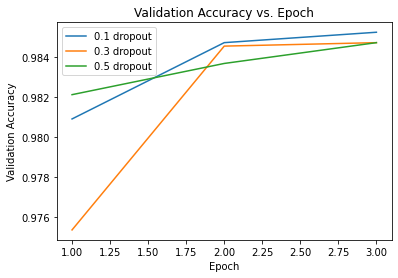

In [78]:
# Plot validation Loss vs. Epoch
for val_accuracy,dropout in zip(val_accuracies,dropouts):    
    plt.plot(range(1,4),val_accuracy,label=f'{dropout} dropout')
plt.title('Validation Accuracy vs. Epoch')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
x1,x2,y1,y2 = plt.axis()
plt.legend()
plt.show() 

### Initial Learning Rate Fine-tuning

In [79]:
# Lets try choose the right dropout amount
#https://www.tensorflow.org/tutorials/text/classify_text_with_bert#choose_a_bert_model_to_fine-tune
learningRates = [5e-5,3e-5,2e-5]
val_accuracies=[]
for learningRate in learningRates:
  bert_model = BERT_champion_nn(0.1)
  optimizer = optimization.create_optimizer(init_lr=learningRate,
                                            num_train_steps=num_train_steps,
                                            num_warmup_steps=num_warmup_steps,
                                            optimizer_type='adamw')
  bert_model.compile(optimizer=optimizer,
                          loss=loss,
                          metrics=metrics)
  history = bert_model.fit(
      raw_train_ds,
      validation_data=raw_val_ds,
      epochs=epochs)
  print(f'Learning Rate {learningRate}: done.')
  val_accuracies.append(history.history['val_binary_accuracy'])

Epoch 1/3
360/360 [==============================] - 147s 391ms/step - loss: 0.2693 - binary_accuracy: 0.9336 - val_loss: 0.0608 - val_binary_accuracy: 0.9802
Epoch 2/3
360/360 [==============================] - 141s 393ms/step - loss: 0.0393 - binary_accuracy: 0.9871 - val_loss: 0.0545 - val_binary_accuracy: 0.9856
Epoch 3/3
360/360 [==============================] - 142s 393ms/step - loss: 0.0171 - binary_accuracy: 0.9949 - val_loss: 0.0590 - val_binary_accuracy: 0.9852
Learning Rate 5e-05: done.


Epoch 1/3
360/360 [==============================] - 148s 396ms/step - loss: 0.2907 - binary_accuracy: 0.9292 - val_loss: 0.0540 - val_binary_accuracy: 0.9833
Epoch 2/3
360/360 [==============================] - 142s 395ms/step - loss: 0.0477 - binary_accuracy: 0.9838 - val_loss: 0.0528 - val_binary_accuracy: 0.9852
Epoch 3/3
360/360 [==============================] - 143s 398ms/step - loss: 0.0234 - binary_accuracy: 0.9919 - val_loss: 0.0558 - val_binary_accuracy: 0.9859
Learning Rate 3e-05: done.


Epoch 1/3
360/360 [==============================] - 150s 393ms/step - loss: 0.3212 - binary_accuracy: 0.9188 - val_loss: 0.0669 - val_binary_accuracy: 0.9771
Epoch 2/3
360/360 [==============================] - 141s 391ms/step - loss: 0.0494 - binary_accuracy: 0.9817 - val_loss: 0.0542 - val_binary_accuracy: 0.9837
Epoch 3/3
360/360 [==============================] - 140s 390ms/step - loss: 0.0348 - binary_accuracy: 0.9880 - val_loss: 0.0521 - val_binary_accuracy: 0.9842
Learning Rate 2e-05: done.


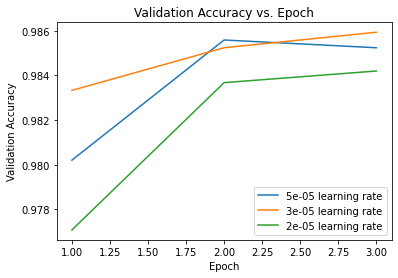

In [81]:
# Plot validation Loss vs. Epoch
for val_accuracy,learningRate in zip(val_accuracies,learningRates):    
    plt.plot(range(1,4),val_accuracy,label=f'{learningRate} learning rate')
plt.title('Validation Accuracy vs. Epoch')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
x1,x2,y1,y2 = plt.axis()
plt.legend()
plt.show() 

### Label Smoothing Fine Tuning

In [82]:
# Lets try choose the right dropout amount
#https://www.tensorflow.org/tutorials/text/classify_text_with_bert#choose_a_bert_model_to_fine-tune
labelSmoothings = [.1,.3,.5]
val_accuracies=[]
for labelSmoothing in labelSmoothings:
  bert_model = BERT_champion_nn(0.1)
  loss=losses.BinaryCrossentropy(from_logits=True,label_smoothing=labelSmoothing)
  optimizer = optimization.create_optimizer(init_lr=3e-5,
                                            num_train_steps=num_train_steps,
                                            num_warmup_steps=num_warmup_steps,
                                            optimizer_type='adamw')
  bert_model.compile(optimizer=optimizer,
                          loss=loss,
                          metrics=metrics)
  history = bert_model.fit(
      raw_train_ds,
      validation_data=raw_val_ds,
      epochs=epochs)
  print(f'Label Smoothing {labelSmoothing}: done.')
  val_accuracies.append(history.history['val_binary_accuracy'])

Epoch 1/3
360/360 [==============================] - 146s 390ms/step - loss: 0.4096 - binary_accuracy: 0.9316 - val_loss: 0.2354 - val_binary_accuracy: 0.9825
Epoch 2/3
360/360 [==============================] - 141s 391ms/step - loss: 0.2402 - binary_accuracy: 0.9826 - val_loss: 0.2422 - val_binary_accuracy: 0.9783
Epoch 3/3
360/360 [==============================] - 140s 389ms/step - loss: 0.2240 - binary_accuracy: 0.9914 - val_loss: 0.2295 - val_binary_accuracy: 0.9847
Label Smoothing 0.1: done.


Epoch 1/3
360/360 [==============================] - 145s 389ms/step - loss: 0.5754 - binary_accuracy: 0.9283 - val_loss: 0.4483 - val_binary_accuracy: 0.9788
Epoch 2/3
360/360 [==============================] - 140s 388ms/step - loss: 0.4604 - binary_accuracy: 0.9783 - val_loss: 0.4430 - val_binary_accuracy: 0.9795
Epoch 3/3
360/360 [==============================] - 140s 389ms/step - loss: 0.4514 - binary_accuracy: 0.9872 - val_loss: 0.4406 - val_binary_accuracy: 0.9816
Label Smoothing 0.3: done.


Epoch 1/3
360/360 [==============================] - 148s 390ms/step - loss: 0.7005 - binary_accuracy: 0.8870 - val_loss: 0.5837 - val_binary_accuracy: 0.9701
Epoch 2/3
360/360 [==============================] - 141s 392ms/step - loss: 0.5964 - binary_accuracy: 0.9586 - val_loss: 0.5726 - val_binary_accuracy: 0.9802
Epoch 3/3
360/360 [==============================] - 142s 394ms/step - loss: 0.5908 - binary_accuracy: 0.9711 - val_loss: 0.5710 - val_binary_accuracy: 0.9819
Label Smoothing 0.5: done.


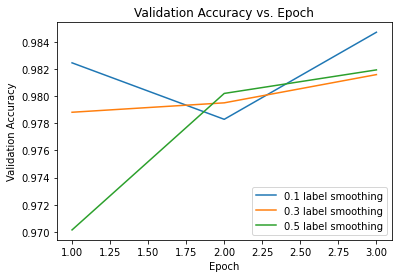

In [84]:
# Plot validation Loss vs. Epoch
for val_accuracy,labelSmoothing in zip(val_accuracies,labelSmoothings):    
    plt.plot(range(1,4),val_accuracy,label=f'{labelSmoothing} label smoothing')
plt.title('Validation Accuracy vs. Epoch')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
x1,x2,y1,y2 = plt.axis()
plt.legend()
plt.show() 

## Final Model

In [86]:
best_bert_model = BERT_champion_nn(0.1)
loss=losses.BinaryCrossentropy(from_logits=True,label_smoothing=0.1)
optimizer = optimization.create_optimizer(init_lr=3e-5,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
best_bert_model.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=metrics)
history = best_bert_model.fit(
    raw_train_ds,
    validation_data=raw_val_ds,
    epochs=epochs)

Epoch 1/3


360/360 [==============================] - 149s 395ms/step - loss: 0.4285 - binary_accuracy: 0.9217 - val_loss: 0.2450 - val_binary_accuracy: 0.9793
Epoch 2/3
360/360 [==============================] - 143s 396ms/step - loss: 0.2388 - binary_accuracy: 0.9849 - val_loss: 0.2303 - val_binary_accuracy: 0.9845
Epoch 3/3
360/360 [==============================] - 142s 395ms/step - loss: 0.2248 - binary_accuracy: 0.9902 - val_loss: 0.2270 - val_binary_accuracy: 0.9852


In [88]:
bert_accuracy,bert_tweet_accuracy = runEvaluation(best_bert_model)
print('same dataset evaluation accuracy:')
print(bert_accuracy)
print('twitter dataset evaluation accuracy:')
print(bert_tweet_accuracy)

same dataset evaluation accuracy:
0.9865625
twitter dataset evaluation accuracy:
0.6094
